In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional



In [21]:
from sklearn.preprocessing import RobustScaler


In [15]:
import datetime

In [25]:
df = pd.read_csv('filtered_data.csv')


In [26]:
# convert to numerical
df = df.astype('category')
column = df.select_dtypes(['category']).columns
df[column] = df[column].apply(lambda x: x.cat.codes)

In [27]:
#separating hand,leg,chest data
hcols = [8,9,10,11,12,13,18]
df_hand = df[df.columns[hcols]]
lcols = [2,3,4,5,6,7,18]
df_leg = df[df.columns[lcols]]
ccols = [14,15,16,17,18]
df_chest = df[df.columns[ccols]]

In [28]:
df_hand

,Accel X (g)_hand,Accel Y (g)_hand,Accel Z (g)_hand,Gyro X (°/s)_hand,Gyro Y (°/s)_hand,Gyro Z (°/s)_hand,Activity_Label
0,24053,7520,18463,4138,7044,5425,4
1,24199,7413,18548,3982,7099,5456,4
2,24225,7316,18634,3877,7142,5467,4
3,24259,7219,18747,3817,7172,5472,4
4,24248,7148,18887,3803,7182,5477,4
...,...,...,...,...,...,...,...
142068,13968,15515,12486,4717,6576,5170,0
142069,13478,15182,12429,4451,6589,5032,0
142070,13020,14411,12608,4233,6575,4971,0
142071,13885,14386,12163,4414,6540,5007,0


In [29]:
df_train = df.sample(frac=0.7)
df_test = df.loc[~df.index.isin(df_train.index)]

#scaling the data
from sklearn.preprocessing import MinMaxScaler
Scaler= MinMaxScaler()
df_hand['Accel X (g)_hand']=Scaler.fit_transform(df_hand['Accel X (g)_hand'].values.reshape(-1, 1))
df_hand['Accel Y (g)_hand']=Scaler.fit_transform(df_hand['Accel Y (g)_hand'].values.reshape(-1, 1))
df_hand['Accel Z (g)_hand']=Scaler.fit_transform(df_hand['Accel Z (g)_hand'].values.reshape(-1, 1))
df_hand['Gyro X (°/s)_hand']=Scaler.fit_transform(df_hand['Gyro X (°/s)_hand'].values.reshape(-1, 1))
df_hand['Gyro Y (°/s)_hand']=Scaler.fit_transform(df_hand['Gyro Y (°/s)_hand'].values.reshape(-1, 1))
df_hand['Gyro Z (°/s)_hand']=Scaler.fit_transform(df_hand['Gyro Z (°/s)_hand'].values.reshape(-1, 1))

In [30]:
scale_columns = ['Accel X (g)_hand', 'Accel Y (g)_hand', 'Accel Z (g)_hand','Gyro X (°/s)_hand','Gyro Y (°/s)_hand','Gyro Z (°/s)_hand']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(
  df_train[scale_columns].to_numpy()
)

df_test.loc[:, scale_columns] = scaler.transform(
  df_test[scale_columns].to_numpy()
)

In [31]:
df_hand

,Accel X (g)_hand,Accel Y (g)_hand,Accel Z (g)_hand,Gyro X (°/s)_hand,Gyro Y (°/s)_hand,Gyro Z (°/s)_hand,Activity_Label
0,24053,7520,18463,4138,7044,5425,4
1,24199,7413,18548,3982,7099,5456,4
2,24225,7316,18634,3877,7142,5467,4
3,24259,7219,18747,3817,7172,5472,4
4,24248,7148,18887,3803,7182,5477,4
...,...,...,...,...,...,...,...
142068,13968,15515,12486,4717,6576,5170,0
142069,13478,15182,12429,4451,6589,5032,0
142070,13020,14411,12608,4233,6575,4971,0
142071,13885,14386,12163,4414,6540,5007,0


In [32]:
df_hand.columns

Index(['Accel X (g)_hand', 'Accel Y (g)_hand', 'Accel Z (g)_hand',
       'Gyro X (°/s)_hand', 'Gyro Y (°/s)_hand', 'Gyro Z (°/s)_hand',
       'Activity_Label'],
      dtype='object')

In [33]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [34]:
TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['Accel X (g)_hand', 'Accel Y (g)_hand', 'Accel Z (g)_hand','Gyro X (°/s)_hand','Gyro Y (°/s)_hand','Gyro Z (°/s)_hand']],
    df_train.Activity_Label,
    TIME_STEPS,
    STEP
)

X_test, y_test = create_dataset(
    df_test[['Accel X (g)_hand', 'Accel Y (g)_hand', 'Accel Z (g)_hand','Gyro X (°/s)_hand','Gyro Y (°/s)_hand','Gyro Z (°/s)_hand']],
    df_test.Activity_Label,
    TIME_STEPS,
    STEP
)

In [36]:
from sklearn.preprocessing import OneHotEncoder

In [37]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [39]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['acc']
)

In [40]:

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/20
70/70 [==============================] - 7s 73ms/step - loss: 0.3958 - acc: 0.9077 - val_loss: 0.2434 - val_acc: 0.9357
Epoch 2/20
70/70 [==============================] - 5s 68ms/step - loss: 0.3221 - acc: 0.9109 - val_loss: 0.2422 - val_acc: 0.9357
Epoch 3/20
70/70 [==============================] - 5s 68ms/step - loss: 0.3175 - acc: 0.9109 - val_loss: 0.2430 - val_acc: 0.9357
Epoch 4/20
70/70 [==============================] - 5s 68ms/step - loss: 0.3149 - acc: 0.9109 - val_loss: 0.2450 - val_acc: 0.9357
Epoch 5/20
70/70 [==============================] - 5s 69ms/step - loss: 0.3099 - acc: 0.9109 - val_loss: 0.2447 - val_acc: 0.9357
Epoch 6/20
70/70 [==============================] - 5s 69ms/step - loss: 0.3119 - acc: 0.9109 - val_loss: 0.2488 - val_acc: 0.9357
Epoch 7/20
70/70 [==============================] - 5s 68ms/step - loss: 0.3090 - acc: 0.9109 - val_loss: 0.2469 - val_acc: 0.9357
Epoch 8/20
70/70 [==============================] - 5s 69ms/step - loss: 0.3087 - a

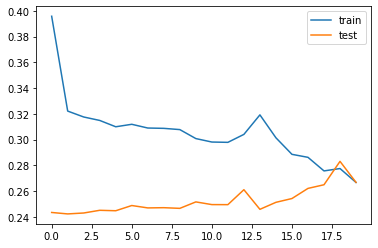

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [41]:
model.evaluate(X_test, y_test)


34/34 [==============================] - 1s 27ms/step - loss: 2.9463 - acc: 0.3412


[2.9463491439819336, 0.34118756651878357]

In [42]:
y_pred = model.predict(X_test)


34/34 [==============================] - 1s 26ms/step


In [47]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!